## Dependencies

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

### Connecting to PostgreSQL database

In [2]:
from sqlalchemy import create_engine
import db_credentials

In [3]:
# Using the database credentials
db_connection = db_credentials.db_credentials

In [4]:
# Accessing individual credentials from the dictionary of credentials
user = db_connection['user']
password = db_connection['password']
host = db_connection['host']
port = db_connection['port']
database = db_connection['database']

# Creating connection string
connection_str = f'postgresql://{user}:{password}@{host}:{port}/{database}'

# SQLAlchemy engine
engine = create_engine(connection_str)

# Test if the connection is made or not
try:
    with engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as ex:
    print(f'Sorry failed to connect: {ex}')

Successfully connected to the PostgreSQL database


### Query data from PostgreSQL and create a DataFrame 

In [5]:
# Establish a connection to the PostgreSQL database (This connection allows us to execute SQL querie)
conn = engine.connect()

# Execute SQL query
result = conn.execute('SELECT * FROM "AIDs_Classifications"')
        
# Fetch all rows from the result set
rows = result.fetchall()
        
# Convert result set to DataFrame
AIDS_df = pd.DataFrame(rows, columns=result.keys())
        
# Print the DataFrame
AIDS_df.head()

,ID,treatment,ZDV_only_treatment,off_treatment,time,age,weight,hemophilia,homosexual_activity,drugs,...,ZDV_last_30days,prior_ART_length,ART_history,ART_history_stratified,symptom,cd4_base,cd4_20wks,cd8_base,cd8_20wks,infected
0,0,2,1,0,948,48,89.8128,0,0,0,...,0,0,0,1,0,422,477,566,324,0
1,1,3,1,0,1002,61,49.4424,0,0,0,...,1,895,1,3,0,162,218,392,564,1
2,2,3,1,1,961,45,88.4520,0,1,1,...,1,707,1,3,0,326,274,2063,1893,0
3,3,3,1,0,1166,47,85.2768,0,1,0,...,1,1399,1,3,0,287,394,1590,966,0
4,4,0,0,0,1090,43,66.6792,0,1,0,...,1,1352,1,3,0,504,353,870,782,0


## Preprocessing

In [6]:
# This can be used for getting the data directly from the CSV located in the Resources folder
# AIDS_df = pd.read_csv('Resources/AIDS_Classifications_cleaned.csv')

In [7]:
# Drop the non-benificial "ID" column
# AIDS_df = AIDS_df.drop(['ID', 'cd8_base', 'cd8_20wks'], axis = 1)
AIDS_df.head()

,ID,treatment,ZDV_only_treatment,off_treatment,time,age,weight,hemophilia,homosexual_activity,drugs,...,ZDV_last_30days,prior_ART_length,ART_history,ART_history_stratified,symptom,cd4_base,cd4_20wks,cd8_base,cd8_20wks,infected
0,0,2,1,0,948,48,89.8128,0,0,0,...,0,0,0,1,0,422,477,566,324,0
1,1,3,1,0,1002,61,49.4424,0,0,0,...,1,895,1,3,0,162,218,392,564,1
2,2,3,1,1,961,45,88.4520,0,1,1,...,1,707,1,3,0,326,274,2063,1893,0
3,3,3,1,0,1166,47,85.2768,0,1,0,...,1,1399,1,3,0,287,394,1590,966,0
4,4,0,0,0,1090,43,66.6792,0,1,0,...,1,1352,1,3,0,504,353,870,782,0


In [8]:
# Determine the number of unique values in each column.
AIDS_df.nunique()

ID                        2139
treatment                    4
ZDV_only_treatment           2
off_treatment                2
time                       713
age                         59
weight                     667
hemophilia                   2
homosexual_activity          2
drugs                        2
race                         2
gender                       2
karnofsky_score              4
therapy_prior                2
ZDV_last_30days              2
prior_ART_length           813
ART_history                  2
ART_history_stratified       3
symptom                      2
cd4_base                   484
cd4_20wks                  570
cd8_base                  1090
cd8_20wks                 1050
infected                     2
dtype: int64

In [9]:
# Print DataFrame structure
print(AIDS_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2139 non-null   int64  
 1   treatment               2139 non-null   int64  
 2   ZDV_only_treatment      2139 non-null   int64  
 3   off_treatment           2139 non-null   int64  
 4   time                    2139 non-null   int64  
 5   age                     2139 non-null   int64  
 6   weight                  2139 non-null   float64
 7   hemophilia              2139 non-null   int64  
 8   homosexual_activity     2139 non-null   int64  
 9   drugs                   2139 non-null   int64  
 10  race                    2139 non-null   int64  
 11  gender                  2139 non-null   int64  
 12  karnofsky_score         2139 non-null   int64  
 13  therapy_prior           2139 non-null   int64  
 14  ZDV_last_30days         2139 non-null   

In [10]:
# There are significantly more '0's than '1's
infected_count = AIDS_df["infected"].value_counts()
infected_count

infected
0    1618
1     521
Name: count, dtype: int64

### Handling class imbalance
The above code indicates that our classes are very imbalanced. Handling class imbalance is crucial in machine learning when one class has significantly more samples than the other. 
To handle this issue we have used the following strategies:
1.	Algorithmic techniques: adjust the class weights in the model to penalize misclassifications of the minority class more than the majority class. This can be achieved by setting the class_weight parameter to “balanced” in some models such as Logistic Regression and SVM 

2.	Using ensemble methods like Random Forests which inherently handle class imbalance by combining multiple weak learners.
3.	Evaluation Metrics: Use appropriate evaluation metrics that are less sensitive to class imbalance, such as precision, and recall rather than accuracy.



In [11]:
# Split our preprocessed data into our features and target arrays
y = AIDS_df['infected'].ravel()
x = AIDS_df.drop(columns='infected')

# Define the train-test split size
test_size = 0.2
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=1)


In [12]:
# print the number and shape of train and test data
print(f"Feature=> train: {X_train.shape} - test: {X_test.shape}")
print(f"Label=> train: {y_train.shape} - test: {y_test.shape}")

Feature=> train: (1711, 23) - test: (428, 23)
Label=> train: (1711,) - test: (428,)


In [13]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Model 1: Logistic Regression + Model 2: K-NearestNeighbors (KNN) + Model 3: Support Vector Machine (SVM) 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support


# Define different train-test split ratios for evaluation
train_splits = [0.7, 0.5, 0.3]

# Define a function to evaluate models
def evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    # Train the model using the training data
    model.fit(X_train_scaled, y_train)
    
    # Create predictions using the training and testing data
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate accuracy
    acc_train = model.score(X_train_scaled, y_train)
    acc_test = model.score(X_test_scaled, y_test)
    
    # Calculate precision, recall, F1-score, and support
    p_train, r_train, f1_train, support_train = precision_recall_fscore_support(y_train, y_pred_train, average='macro')
    p_test, r_test, f1_test, support_test = precision_recall_fscore_support(y_test, y_pred_test, average='macro')
    
    # Generate classification report
    report = classification_report(y_test, y_pred_test, target_names=["not infected", "infected"])
    
    return acc_train, acc_test, p_train, r_train, f1_train, support_train, p_test, r_test, f1_test, support_test, report

# Iterate over different train-test split ratios and evaluate each model
for split in train_splits:
    print(f"Train-Test Split Ratio: {split}")
    print("---------------------------------------")
    
    # Split the data into training and testing sets
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(x, y, test_size=1 - split, random_state=42)
    X_train_scaled_split = X_scaler.transform(X_train_split)
    X_test_scaled_split = X_scaler.transform(X_test_split)
    
    # Logistic Regression
    logistic_reg = LogisticRegression(solver='lbfgs', max_iter=200, random_state=1, class_weight="balanced")
    acc_train_logistic_reg, acc_test_logistic_reg, p_train_logistic_reg, r_train_logistic_reg, f1_train_logistic_reg, support_train_logistic_reg, p_test_logistic_reg, r_test_logistic_reg, f1_test_logistic_reg, support_test_logistic_reg, report_logistic_reg = evaluate_model(logistic_reg, X_train_scaled_split, X_test_scaled_split, y_train_split, y_test_split)
    print("Logistic Regression:")
    print(f"Accuracy (Train): {acc_train_logistic_reg}")
    print(f"Accuracy (Test): {acc_test_logistic_reg}")
    print(f"Precision (Train): {p_train_logistic_reg}")
    print(f"Recall (Train): {r_train_logistic_reg}")
    print(f"F1-score (Train): {f1_train_logistic_reg}")
    print(f"Support (Train): {support_train_logistic_reg}")
    print(f"Precision (Test): {p_test_logistic_reg}")
    print(f"Recall (Test): {r_test_logistic_reg}")
    print(f"F1-score (Test): {f1_test_logistic_reg}")
    print(f"Support (Test): {support_test_logistic_reg}")
    print("Classification Report:")
    print(report_logistic_reg)
    print("---------------------------------------")
    
    # K-Nearest Neighbors
    knn = KNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
    acc_train_knn, acc_test_knn, p_train_knn, r_train_knn, f1_train_knn, support_train_knn, p_test_knn, r_test_knn, f1_test_knn, support_test_knn, report_knn = evaluate_model(knn, X_train_scaled_split, X_test_scaled_split, y_train_split, y_test_split)
    print("K-Nearest Neighbors:")
    print(f"Accuracy (Train): {acc_train_knn}")
    print(f"Accuracy (Test): {acc_test_knn}")
    print(f"Precision (Train): {p_train_knn}")
    print(f"Recall (Train): {r_train_knn}")
    print(f"F1-score (Train): {f1_train_knn}")
    print(f"Support (Train): {support_train_knn}")
    print(f"Precision (Test): {p_test_knn}")
    print(f"Recall (Test): {r_test_knn}")
    print(f"F1-score (Test): {f1_test_knn}")
    print(f"Support (Test): {support_test_knn}")
    print("Classification Report:")
    print(report_knn)
    print("---------------------------------------")
    
    # Support Vector Machine
    svm = SVC(kernel='linear', class_weight="balanced")
    acc_train_svm, acc_test_svm, p_train_svm, r_train_svm, f1_train_svm, support_train_svm, p_test_svm, r_test_svm, f1_test_svm, support_test_svm, report_svm = evaluate_model(svm, X_train_scaled_split, X_test_scaled_split, y_train_split, y_test_split)
    print("Support Vector Machine:")
    print(f"Accuracy (Train): {acc_train_svm}")
    print(f"Accuracy (Test): {acc_test_svm}")
    print(f"Precision (Train): {p_train_svm}")
    print(f"Recall (Train): {r_train_svm}")
    print(f"F1-score (Train): {f1_train_svm}")
    print(f"Support (Train): {support_train_svm}")
    print(f"Precision (Test): {p_test_svm}")
    print(f"Recall (Test): {r_test_svm}")
    print(f"F1-score (Test): {f1_test_svm}")
    print(f"Support (Test): {support_test_svm}")
    print("Classification Report:")
    print(report_svm)
    print("---------------------------------------")



Train-Test Split Ratio: 0.7
---------------------------------------
Logistic Regression:
Accuracy (Train): 0.8623914495657983
Accuracy (Test): 0.8489096573208723
Precision (Train): 0.8093943575523566
Recall (Train): 0.8440389176630041
F1-score (Train): 0.8237422325458046
Support (Train): None
Precision (Test): 0.792445431181148
Recall (Test): 0.8196818613485279
F1-score (Test): 0.8041174527782584
Support (Test): None
Classification Report:
              precision    recall  f1-score   support

not infected       0.92      0.88      0.90       486
    infected       0.66      0.76      0.71       156

    accuracy                           0.85       642
   macro avg       0.79      0.82      0.80       642
weighted avg       0.86      0.85      0.85       642

---------------------------------------
K-Nearest Neighbors:
Accuracy (Train): 0.8804275217100869
Accuracy (Test): 0.7975077881619937
Precision (Train): 0.8673642568281457
Recall (Train): 0.7928493634735466
F1-score (Train): 0.82

Comparing the results for three available distributions of the dataset indicates that all three models have a better performance when train_test split ratio distribution is considered 70:30 (or 0.7).
We have used the results for this distribution in the final comparison.


In [15]:
# SVM modelcompare the actual and predicated dataset
# Select a subset of your dataset (e.g., first 100 samples)
subset_X = pd.DataFrame(X_test_scaled[:100])
subset_y_actual = pd.Series(y_test[:100])

# Predictions on the subset
subset_y_pred = svm.predict(subset_X)

# Comparison
comparison_df = pd.DataFrame({'Actual': subset_y_actual, 'Predicted': subset_y_pred})

print(comparison_df)

    Actual  Predicted
0        0          0
1        0          0
2        1          1
3        0          0
4        0          0
..     ...        ...
95       1          1
96       0          0
97       1          0
98       0          1
99       0          0

[100 rows x 2 columns]


## Methodology:
We utilized three traditional classification algorithms: Logistic Regression, K-Nearest Neighbors (KNN), and Support Vector Machine (SVM).  
The dataset was split into training and testing sets using different train-test split ratios: 70:30, 50:50, and 30:70.  
Evaluation metrics included accuracy, precision, recall, F1-score, and support.  

## Logistic Regression:  
Achieved an accuracy of approximately 85% across all train-test split ratios.  
Displayed balanced precision and recall for the "not infected" class, indicating robust performance in correctly identifying individuals not infected with the AIDS virus.  
However, precision and recall for the "infected" class were relatively lower, suggesting challenges in correctly classifying individuals infected with the virus.  

## K-Nearest Neighbors (KNN):  
Produced an accuracy ranging from 81% to 82%.  
Demonstrated relatively lower precision and recall for both classes compared to Logistic Regression, indicating a less optimal performance in classification.  

## Support Vector Machine (SVM):  
Attained an accuracy similar to Logistic Regression, ranging from 84% to 85%.  
Showed balanced precision and recall for both classes, indicating effective classification performance.  
After evaluating the performance of the SVM model with subset of the data, the model seems to perform reasonably well on the subset  of data, correctly predicting the outcomes for many samples. 



## Model 4_1: Deep Neural Networks(DNN)

In [16]:
# Define a function to calculate accuracy_score, precision_score, and recall_score for different algorithms
from sklearn.metrics import accuracy_score, precision_score, recall_score
def calculate_metrics(y_train, y_test, y_pred_train, y_pred_test):
    acc_train = round(accuracy_score(y_true=y_train, y_pred=y_pred_train), 2)
    acc_test = round(accuracy_score(y_true=y_test, y_pred=y_pred_test), 2)

    p = round(precision_score(y_true=y_test, y_pred=y_pred_test), 2)
    r = round(recall_score(y_true=y_test, y_pred=y_pred_test), 2)

    print(f"acc train: {acc_train}, acc test: {acc_test}, precision: {p}, recall: {r}")

    return acc_train, acc_test, p, r

#### Compile, Train and Evaluate the Model

In [17]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer
# Determine the number of input features
input_features = X_train.shape[1]

# Create the Keras Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=80, activation='relu', input_dim=input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=30, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 80)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,381 (17.11 KB)

 Trainable params: 4,381 (17.11 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6569 - loss: 0.6062 
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8231 - loss: 0.4045
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.8555 - loss: 0.3406
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.8767 - loss: 0.3091
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.8853 - loss: 0.2860
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.8905 - loss: 0.2748
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.9017 - loss: 0.2525
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.9100 - loss: 0.2332
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.9061 - loss: 0.2437
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.9149 - loss: 0.2216
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.9224 - loss: 0.1959
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step 

In [20]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = nn.predict(X_train_scaled)>0.5
y_pred_test = nn.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_1: ")
acc_train_knn, acc_test_knn, p_knn, r_knn = calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Metrics for Nural Network model_1: 
acc train: 0.99, acc test: 0.89, precision: 0.82, recall: 0.75


In [21]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

14/14 - 0s - 8ms/step - accuracy: 0.8855 - loss: 0.3900
Loss: 0.3899717628955841, Accuracy: 0.8855140209197998


## Model 4_2: Deep Neural Networks(DNN)

Attempt 1: Use same structure but different number of nurons in each layer and increasing the Epoch from 50 t0 100. Also the number of units from 80 and 30 have changed to 14 and 7 as well.

In [22]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# Determine the number of input features
number_input_features = len( X_train_scaled[0])
hidden_nodes_layer1=14
hidden_nodes_layer2=7
nn = tf.keras.models.Sequential()

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='relu'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 14)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449 (1.75 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5650 - loss: 0.6931 
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7556 - loss: 0.5527
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8040 - loss: 0.4818  
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.8186 - loss: 0.4279
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8392 - loss: 0.4047
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.8322 - loss: 0.3898
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8315 - loss: 0.3721
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8682 - loss: 0.3295
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.8492 - loss: 0.3637
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8785 - loss: 0.3074
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8711 - loss: 0.3260
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/s

In [25]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = nn.predict(X_train_scaled)>0.5
y_pred_test = nn.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_2: ")
acc_train_nn, acc_test_nn, p_nn, r_nn = calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Metrics for Nural Network model_2: 
acc train: 0.95, acc test: 0.89, precision: 0.81, recall: 0.76


In [26]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

14/14 - 0s - 9ms/step - accuracy: 0.8855 - loss: 0.2835
Loss: 0.28351685404777527, Accuracy: 0.8855140209197998


## Model 4_3: Deep Neural Networks(DNN)

Attempt 2: Optimising the structure using the Keras Tuner

* Allow activation function to choose between relu, sigmoid, tanh
 *  sigmoid is still the only option for the final layer
* Allow number of neurons to vary from 6 to ~75
* Allow for 1, 2, or 3 extra hidden layers (not input or output)


In [27]:
import keras_tuner as kt

NUM_FEATURES = X_train.shape[1]
print("Features:", NUM_FEATURES)

def create_model(hp: kt.HyperParameters) -> tf.keras.models.Sequential:
    model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice("activation", ["relu", "sigmoid", "tanh"])

    # Allow kerastuner to decide number of neurons in first layer
    model.add(tf.keras.layers.Dense(units=hp.Int("first_units", 6, NUM_FEATURES*2, step=6),
                                    activation=activation,
                                    input_dim=NUM_FEATURES))
    
    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     6, NUM_FEATURES*2, step=6),
                                        activation=activation))
    # output layer
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    model.compile(loss="binary_crossentropy",
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

tuner = kt.Hyperband(create_model,
                     objective="val_accuracy",
                     max_epochs=25,
                     overwrite=True,
                     hyperband_iterations=2)

Features: 23


In [28]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,
             y_train,
             epochs=25,
             validation_data=(X_test_scaled, y_test))

Trial 60 Complete [00h 00m 05s]
val_accuracy: 0.8971962332725525

Best val_accuracy So Far: 0.9158878326416016
Total elapsed time: 00h 02m 39s


In [29]:
# Get top 3 model hyperparameters and print the values
top_3_hp = tuner.get_best_hyperparameters(3)
for hparam in top_3_hp:
    print(hparam.values)

# Evaluate the top 3 models against the test dataset
top_3_model = tuner.get_best_models(3)
for model in top_3_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

{'activation': 'relu', 'first_units': 24, 'num_layers': 1, 'units_0': 24, 'units_1': 6, 'units_2': 6, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0023'}
{'activation': 'relu', 'first_units': 24, 'num_layers': 2, 'units_0': 24, 'units_1': 18, 'units_2': 12, 'tuner/epochs': 25, 'tuner/initial_epoch': 9, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0042'}
{'activation': 'tanh', 'first_units': 42, 'num_layers': 1, 'units_0': 30, 'units_1': 24, 'units_2': 6, 'tuner/epochs': 25, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
14/14 - 0s - 11ms/step - accuracy: 0.9159 - loss: 0.2523
Loss: 0.2522963285446167, Accuracy: 0.9158878326416016
14/14 - 0s - 12ms/step - accuracy: 0.9136 - loss: 0.2406
Loss: 0.24057628214359283, Accuracy: 0.913551390171051
14/14 - 0s - 11ms/step - accuracy: 0.9042 - loss: 0.2545
Loss: 0.2544845640659332, Accuracy: 0.9042056202888489


In [30]:
best_tuned_model = tuner.get_best_models(1)[0]
# Evaluate the model using the test data
model_loss2, model_accuracy2 = best_tuned_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss2}, Accuracy: {model_accuracy2}")

14/14 - 0s - 12ms/step - accuracy: 0.9159 - loss: 0.2523
Loss: 0.2522963285446167, Accuracy: 0.9158878326416016


In [31]:
# Define the best model offered by Keras Tuner
input_features = X_train_scaled.shape[1]
best_model = tf.keras.models.Sequential()

# Add the first hidden layer
best_model.add(tf.keras.layers.Dense(units=30, activation='relu', input_dim=input_features))

# Add the second hidden layer
best_model.add(tf.keras.layers.Dense(units=12, activation='relu'))

# Add the third hidden layer
best_model.add(tf.keras.layers.Dense(units=24, activation='relu'))

# Add the output layer
best_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with appropriate number of epochs and batch size
history = best_model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, verbose=2)

# Evaluate the model on the test dataset
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
54/54 - 1s - 16ms/step - accuracy: 0.6756 - loss: 0.6163
Epoch 2/25
54/54 - 0s - 1ms/step - accuracy: 0.7808 - loss: 0.4607
Epoch 3/25
54/54 - 0s - 1ms/step - accuracy: 0.8217 - loss: 0.4031
Epoch 4/25
54/54 - 0s - 1ms/step - accuracy: 0.8428 - loss: 0.3596
Epoch 5/25
54/54 - 0s - 1ms/step - accuracy: 0.8515 - loss: 0.3256
Epoch 6/25
54/54 - 0s - 1ms/step - accuracy: 0.8726 - loss: 0.3032
Epoch 7/25
54/54 - 0s - 1ms/step - accuracy: 0.8819 - loss: 0.2863
Epoch 8/25
54/54 - 0s - 1ms/step - accuracy: 0.8825 - loss: 0.2718
Epoch 9/25
54/54 - 0s - 2ms/step - accuracy: 0.8872 - loss: 0.2615
Epoch 10/25
54/54 - 0s - 1ms/step - accuracy: 0.8954 - loss: 0.2497
Epoch 11/25
54/54 - 0s - 1ms/step - accuracy: 0.9006 - loss: 0.2393
Epoch 12/25
54/54 - 0s - 1ms/step - accuracy: 0.8995 - loss: 0.2316
Epoch 13/25
54/54 - 0s - 1ms/step - accuracy: 0.9059 - loss: 0.2238
Epoch 14/25
54/54 - 0s - 1ms/step - accuracy: 0.9094 - loss: 0.2168
Epoch 15/25
54/54 - 0s - 1ms/step - accuracy: 0.9106 - l

In [32]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = best_model.predict(X_train_scaled)>0.5
y_pred_test = best_model.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_3: ")
acc_train_best_model, acc_test_best_model, p_best_model, r_best_model = calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
Metrics for Nural Network model_3: 
acc train: 0.94, acc test: 0.89, precision: 0.84, recall: 0.74


## Model 4_4: Deep Neural Networks(DNN)

In this attempt, we will keep the 7 first important features according to the horizontal bar chart plotted in the Random Forest model.

In [33]:
# Drop the columns with lower importance according to the Random Forest "Feature Importance bar chart".
new_AIDS_df = AIDS_df.drop(['ID', 'cd8_base', 'cd8_20wks', 'treatment', 'ZDV_only_treatment', 'hemophilia', 'homosexual_activity', 'drugs', 'race',
       'gender', 'karnofsky_score', 'therapy_prior', 'ZDV_last_30days',
       'ART_history', 'ART_history_stratified', 'symptom'], axis = 1)
new_AIDS_df.head()

,off_treatment,time,age,weight,prior_ART_length,cd4_base,cd4_20wks,infected
0,0,948,48,89.8128,0,422,477,0
1,0,1002,61,49.4424,895,162,218,1
2,1,961,45,88.4520,707,326,274,0
3,0,1166,47,85.2768,1399,287,394,0
4,0,1090,43,66.6792,1352,504,353,0


In [34]:
new_AIDS_df.columns

Index(['off_treatment', 'time', 'age', 'weight', 'prior_ART_length',
       'cd4_base', 'cd4_20wks', 'infected'],
      dtype='object')

In [35]:
# Split our preprocessed data into our features and target arrays
y = new_AIDS_df['infected'].ravel()
x = new_AIDS_df.drop(columns='infected')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=1)

In [36]:
# print the number and shape of train and test data
print(f"Feature=> train: {X_train.shape} - test: {X_test.shape}")
print(f"Label=> train: {y_train.shape} - test: {y_test.shape}")

Feature=> train: (1711, 7) - test: (428, 7)
Label=> train: (1711,) - test: (428,)


In [37]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [38]:
# Define the best model offered by Keras Tuner in previous model but with new DataFrame
input_features = X_train_scaled.shape[1]
best_model = tf.keras.models.Sequential()

# Add the first hidden layer
best_model.add(tf.keras.layers.Dense(units=30, activation='relu', input_dim=input_features))

# Add the second hidden layer
best_model.add(tf.keras.layers.Dense(units=12, activation='relu'))

# Add the third hidden layer
best_model.add(tf.keras.layers.Dense(units=24, activation='relu'))

# Add the output layer
best_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the model
best_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with appropriate number of epochs and batch size
history = best_model.fit(X_train_scaled, y_train, epochs=25, batch_size=32, verbose=2)

# Evaluate the model on the test dataset
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/25
54/54 - 1s - 16ms/step - accuracy: 0.5868 - loss: 0.6758
Epoch 2/25
54/54 - 0s - 1ms/step - accuracy: 0.7937 - loss: 0.5152
Epoch 3/25
54/54 - 0s - 1ms/step - accuracy: 0.8445 - loss: 0.4030
Epoch 4/25
54/54 - 0s - 1ms/step - accuracy: 0.8603 - loss: 0.3471
Epoch 5/25
54/54 - 0s - 1ms/step - accuracy: 0.8673 - loss: 0.3228
Epoch 6/25
54/54 - 0s - 1ms/step - accuracy: 0.8732 - loss: 0.3018
Epoch 7/25
54/54 - 0s - 1ms/step - accuracy: 0.8755 - loss: 0.2869
Epoch 8/25
54/54 - 0s - 1ms/step - accuracy: 0.8819 - loss: 0.2750
Epoch 9/25
54/54 - 0s - 1ms/step - accuracy: 0.8843 - loss: 0.2656
Epoch 10/25
54/54 - 0s - 1ms/step - accuracy: 0.8843 - loss: 0.2585
Epoch 11/25
54/54 - 0s - 1ms/step - accuracy: 0.8890 - loss: 0.2530
Epoch 12/25
54/54 - 0s - 1ms/step - accuracy: 0.8895 - loss: 0.2477
Epoch 13/25
54/54 - 0s - 1ms/step - accuracy: 0.8901 - loss: 0.2430
Epoch 14/25
54/54 - 0s - 1ms/step - accuracy: 0.8954 - loss: 0.2402
Epoch 15/25
54/54 - 0s - 1ms/step - accuracy: 0.8913 - l

In [39]:
# Evaluate the model using the function to calculate different metrics for this model
# Create predictions using the testing data
y_pred_train = best_model.predict(X_train_scaled)>0.5
y_pred_test = best_model.predict(X_test_scaled)>0.5

# Calling the function to calculate the metrics
print(f"Metrics for Nural Network model_4: ")
acc_train_best_model_4, acc_test_best_model_4, p_best_model_4, r_best_model_4 = calculate_metrics(y_train, y_test, y_pred_train, y_pred_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
Metrics for Nural Network model_4: 
acc train: 0.9, acc test: 0.9, precision: 0.86, recall: 0.76


## Model 5: RandomForest Model

In [40]:
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### Create rf_df DataFrame and Add Columns 'cd4_propdif' and 'cd4_numerical_change'

In [41]:
# Calculate proportional differences in CD4 count
rf_df = AIDS_df
rf_df['cd4_propdif'] = (AIDS_df['cd4_20wks'] - AIDS_df['cd4_base']) / AIDS_df['cd4_base']
rf_df['cd4_numerical_change'] = (AIDS_df['cd4_20wks'] - AIDS_df['cd4_base'])

# Display the DataFrame to verify the changes

selected_columns = rf_df[['time', 'age', 'weight', 'cd4_base', 'cd4_20wks', 'cd4_propdif', 'cd4_numerical_change']]

#print
selected_columns.head()

,time,age,weight,cd4_base,cd4_20wks,cd4_propdif,cd4_numerical_change
0,948,48,89.8128,422,477,0.130332,55
1,1002,61,49.4424,162,218,0.345679,56
2,961,45,88.4520,326,274,-0.159509,-52
3,1166,47,85.2768,287,394,0.372822,107
4,1090,43,66.6792,504,353,-0.299603,-151


In [42]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      2139 non-null   int64  
 1   treatment               2139 non-null   int64  
 2   ZDV_only_treatment      2139 non-null   int64  
 3   off_treatment           2139 non-null   int64  
 4   time                    2139 non-null   int64  
 5   age                     2139 non-null   int64  
 6   weight                  2139 non-null   float64
 7   hemophilia              2139 non-null   int64  
 8   homosexual_activity     2139 non-null   int64  
 9   drugs                   2139 non-null   int64  
 10  race                    2139 non-null   int64  
 11  gender                  2139 non-null   int64  
 12  karnofsky_score         2139 non-null   int64  
 13  therapy_prior           2139 non-null   int64  
 14  ZDV_last_30days         2139 non-null   

### DefineFeatures and Target Columns, Train, Make Predictions

In [43]:
# Define Features and Target Columns
feature_columns = ['treatment', 'ZDV_only_treatment', 'off_treatment', 'time', 'age',
                   'weight', 'hemophilia', 'homosexual_activity', 'drugs', 'race',
                   'gender', 'karnofsky_score', 'therapy_prior', 'ZDV_last_30days',
                   'prior_ART_length', 'ART_history', 'ART_history_stratified', 'symptom',
                   'cd4_base', 'cd4_20wks']
target = 'infected'

# Split the data into features and target
X = rf_df[feature_columns]
y = rf_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42)

# Train the Model
random_forest_classifier.fit(X_train, y_train)

# Make Predictions
predictions = random_forest_classifier.predict(X_test)


### Generate Model Statistics

In [44]:
# Calculate Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Calculate Precision
precision = precision_score(y_test, predictions)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, predictions)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(y_test, predictions)
print("F1-score:", f1)

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Generate Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Accuracy: 0.8925233644859814
Precision: 0.8481012658227848
Recall: 0.6633663366336634
F1-score: 0.7444444444444445

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       327
           1       0.85      0.66      0.74       101

    accuracy                           0.89       428
   macro avg       0.88      0.81      0.84       428
weighted avg       0.89      0.89      0.89       428


Confusion Matrix:
[[315  12]
 [ 34  67]]


### Prediction Error Plot

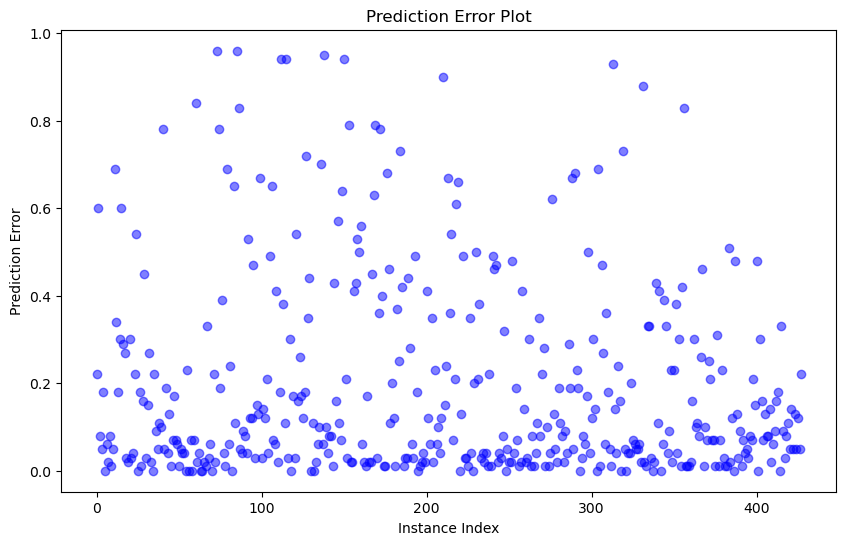

In [45]:
# Calculate prediction probabilities
probabilities = random_forest_classifier.predict_proba(X_test)
predicted_probabilities = probabilities[:, 1]  # Probability of class 1 (positive class)

# Calculate prediction errors
prediction_errors = np.abs(y_test - predicted_probabilities)

# Plot prediction errors
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), prediction_errors, color='blue', alpha=0.5)
plt.title('Prediction Error Plot')
plt.xlabel('Instance Index')
plt.ylabel('Prediction Error')
plt.show()

### Extract and Visualise Feature Importance in the Model

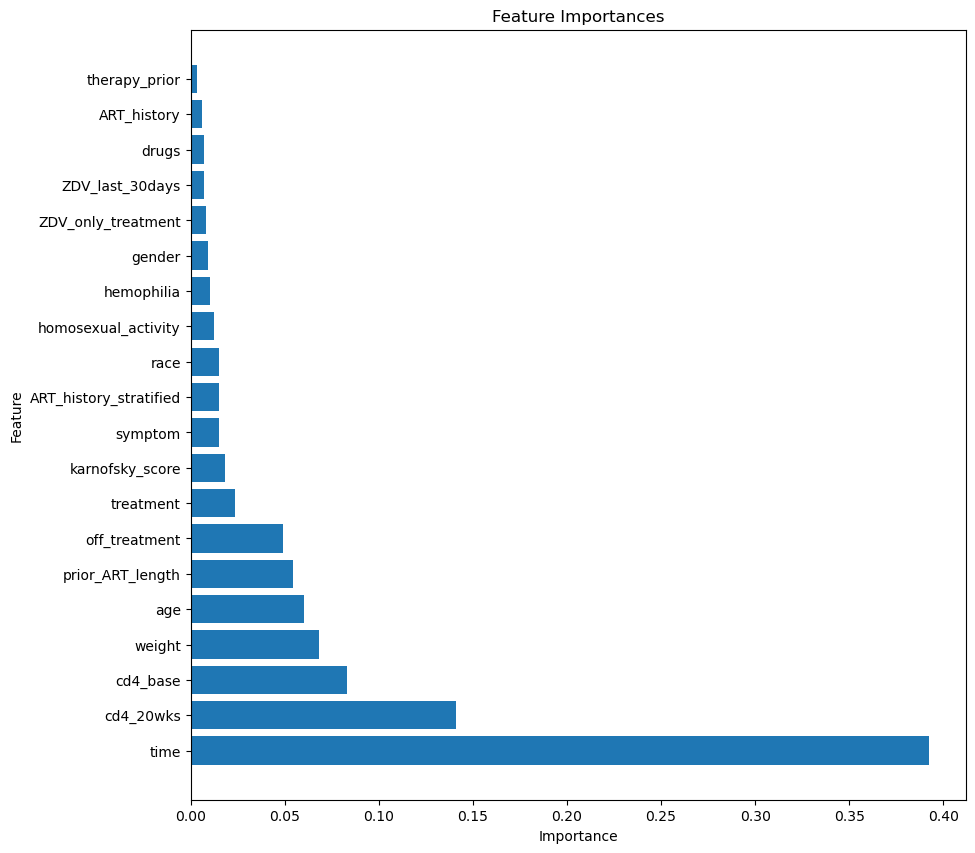

In [46]:
# Extract feature importances
feature_importances = random_forest_classifier.feature_importances_
# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.show()

## Comparission the metrics for all the models

In [51]:
import matplotlib.pyplot as plt

# Define metrics for all models
acc_test = [0.85, 0.82, 0.85, acc_test_best_model_4, 0.89]
precision = [0.67, 0.74, 0.67, p_best_model_4, 0.85]
recall = [0.76, 0.41, 0.77, r_best_model_4, 0.66]
title = ["Logistic Regression", "KNN", "SVM", "DNN", "Random Forest"]
colour = ["blue", "orange", "green", "red", "black"]

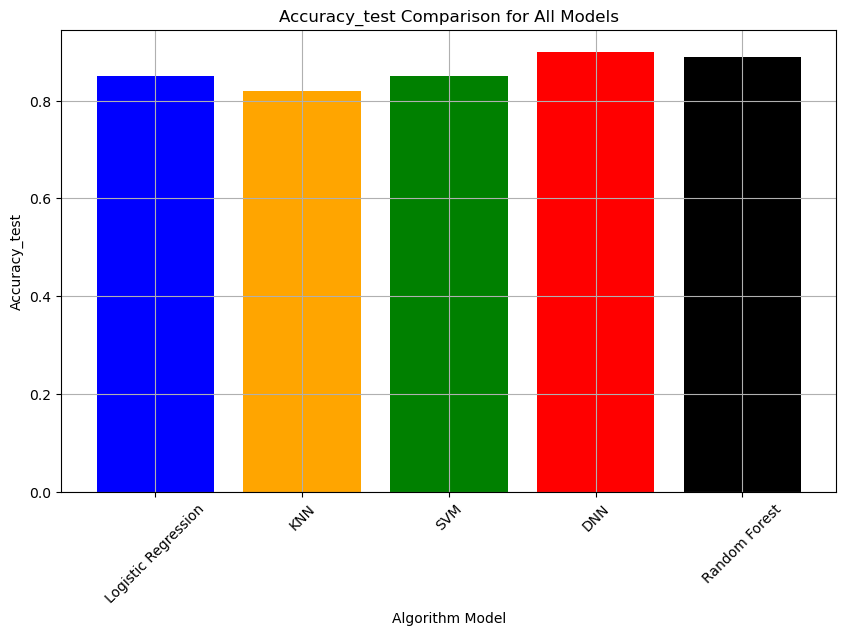

In [52]:
# Plotting accuracy for train and test data
plt.figure(figsize=(10, 6))
plt.bar(title, acc_test, color=colour, label="Test")
plt.grid()
plt.title("Accuracy_test Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Accuracy_test")
plt.xticks(rotation=45)
plt.show()

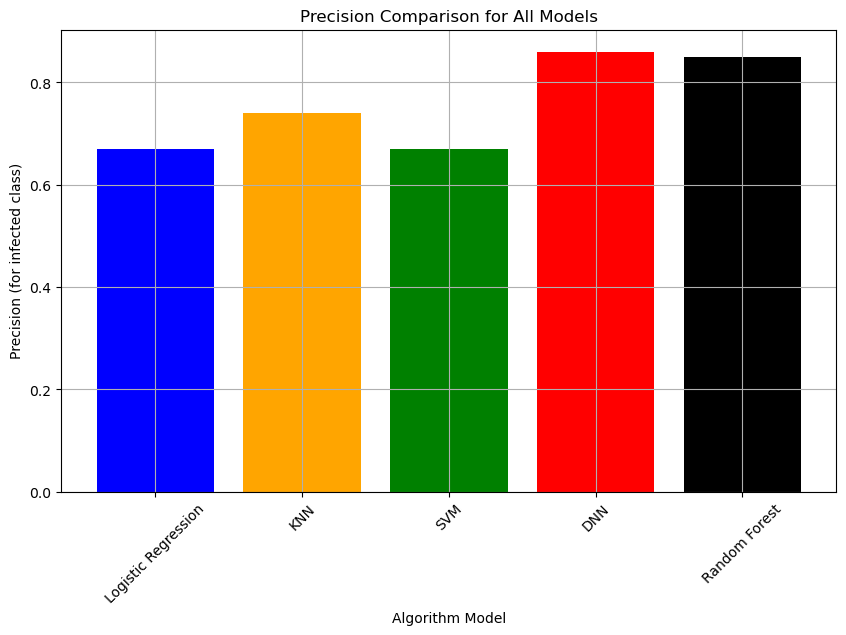

In [53]:
# Plotting precision for all models
plt.figure(figsize=(10, 6))
plt.bar(title, precision, color=colour)
plt.grid()
plt.title("Precision Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Precision (for infected class)")
plt.xticks(rotation=45)
plt.show()

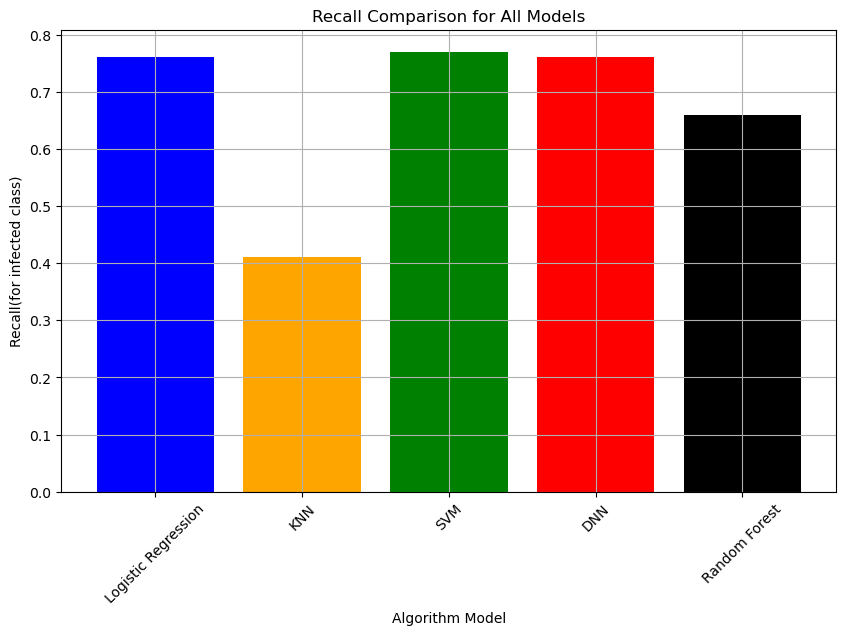

In [54]:
# Plotting recall for all models
plt.figure(figsize=(10, 6))
plt.bar(title, recall, color=colour)
plt.grid()
plt.title("Recall Comparison for All Models")
plt.xlabel("Algorithm Model")
plt.ylabel("Recall(for infected class)")
plt.xticks(rotation=45)
plt.show()

Overall Conclusion:

1. Random Forest provides high accuracy %89 and precision %85, but a low recall for the infected class(class 1) %66.
   
2. Neural Network model in its 4th attempts shows promising performance with high accuracy_train (%90), high accuracy_test (%90) and precision(%86), recall  %76. 
   
According to the concept of our medical dataset and the importance of predicting individuals infected with AIDS in order to getting timely treatment, accuracy and recall for the infected class(class 1)  are considered as the most important metrics for choosing the best model in this project. So Neural Network is the best model with an accuracy of % 90 and a recall of %76.
